<a href="https://colab.research.google.com/github/youuRee/DeepLearning_Lecture/blob/main/Part5/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# 공개 데이터셋에서 학습 데이터를 내려받기
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)

# 공개 데이터셋에서 테스트 데이터를 내려받기
'''test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)'''

In [9]:
batch_size = 100

# 데이터로더 생성
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [10]:
# Hyper-parameters & Variables setting
num_epoch = 200
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
num_channel = 1
dir_name = "GAN_results"

noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# 모델 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(img_size, hidden_size3)
        self.linear2 = nn.Linear(hidden_size3, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size1)
        self.linear4 = nn.Linear(hidden_size1, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(noise_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, img_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = self.tanh(x)
        return x

D = Discriminator().to(device)
G = Generator().to(device)

Using cuda device


In [13]:
# Loss function & Optimizer setting
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

In [15]:
# training

for epoch in range(num_epoch):
    for i, (images, label) in enumerate(train_dataloader):

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 진짜 이미지
        real_images = images.reshape(batch_size, -1).to(device)

        # D가 진짜 이미지를 진짜로 인식
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 가짜 이미지 생성
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = G(z)

        # D가 가짜 이미지를 가짜로 인식
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 Discriminator의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        #------ Discriminator 학습 ------#
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()# Discriminator 학습

        # 생성자가 판별자를 속였는지에 대한 오차(Generator의 loss)를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

         #------ Generator 학습 ------#
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, num_epoch, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/200], d_loss: 0.0348, g_loss: 7.8761, D(x): 0.98, D(G(z)): 0.01
Epoch [1/200], d_loss: 0.0836, g_loss: 6.7791, D(x): 0.97, D(G(z)): 0.03
Epoch [2/200], d_loss: 0.4239, g_loss: 3.6530, D(x): 0.82, D(G(z)): 0.08
Epoch [3/200], d_loss: 0.4789, g_loss: 1.5257, D(x): 0.92, D(G(z)): 0.30
Epoch [4/200], d_loss: 1.4733, g_loss: 3.2651, D(x): 0.63, D(G(z)): 0.05
Epoch [5/200], d_loss: 0.0983, g_loss: 4.6895, D(x): 0.96, D(G(z)): 0.04
Epoch [6/200], d_loss: 0.1777, g_loss: 5.4970, D(x): 0.90, D(G(z)): 0.01
Epoch [7/200], d_loss: 0.5622, g_loss: 4.7489, D(x): 0.84, D(G(z)): 0.06
Epoch [8/200], d_loss: 0.2121, g_loss: 8.5969, D(x): 0.94, D(G(z)): 0.05
Epoch [9/200], d_loss: 0.0558, g_loss: 8.8830, D(x): 1.00, D(G(z)): 0.05
Epoch [10/200], d_loss: 0.2509, g_loss: 7.2502, D(x): 0.91, D(G(z)): 0.01
Epoch [11/200], d_loss: 0.0113, g_loss: 8.0580, D(x): 1.00, D(G(z)): 0.01
Epoch [12/200], d_loss: 0.0066, g_loss: 17.2881, D(x): 0.99, D(G(z)): 0.00
Epoch [13/200], d_loss: 0.3109, g_loss: 8.3294,

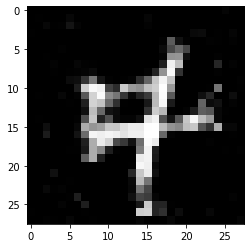

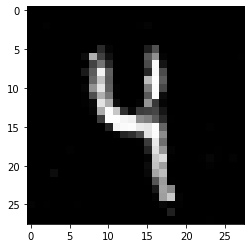

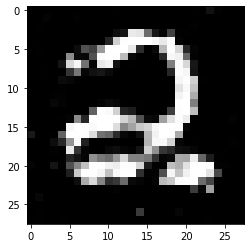

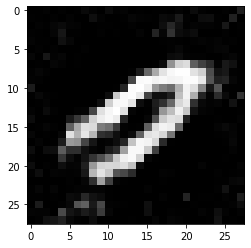

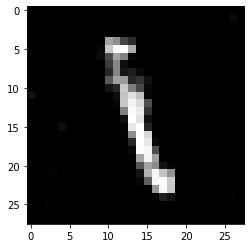

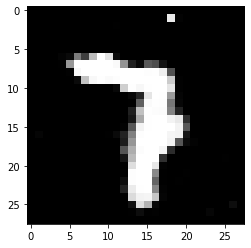

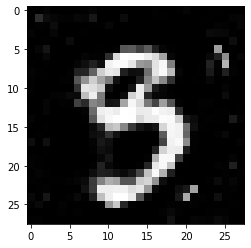

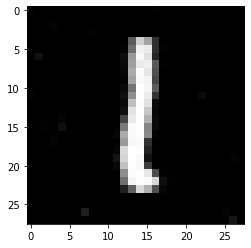

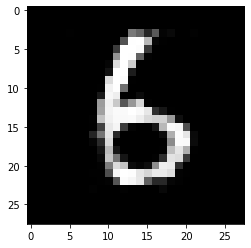

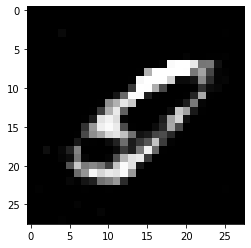

In [17]:
# 생성자가 만들어낸 fake_images 출력
z = torch.randn(batch_size, noise_size).to(device)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()